# Regularized Linear Models

# 요약
### features engineering
- 해당 부분은 크게 신경쓰지 않고 작성된 notebook임. 
- 다른 notebook과 마찬가지로 log-transformation을 통해 skew를 줄이고자 했음. 

### plot
- 해당 notebook에서 특이한 점은 scatter plot을 많이 사용했다는 점이다.
    - prediction vs residual :
        특히 residual(잔차)를 구할 때 x축을 prediction으로 두고 y축을 residual로 했다는 점이 인상깊다. 이게 잔차를 표현하기위해서 올바른 그래프인지는 모르겠지만 잔차 cluster의 중심이 0에 수렴한다는 점을 잘 파악할 수 있었다.
    - A model' prediction vs B model' prediction :
    이 또한 scatter plot을 통해 그래프로 표현했는데 선형관계를 통해 얼마나 유사한지 파악은 할 수 있었지만 정확한 수치적 차이는 확인할 수 없었다.

- 다른 notebook과 비슷하게 overfitting을 그래프를 그려서 파악했다.


### Keras
- 마지막 부분에 Keras를 활용해 모델을 만들었다.
    - 간만에 Keras를 사용해서 몇몇 용어들이 헷갈렸다. 다시 공부해야겠다.

### CV
- validation을 따로 하는 게 아니라 각 알고리즘에 있는 ~CV를 불러와서 진행했다.
    - 해당 라이브러리들은 처음보지만 CV 직관적으로 대략 파악할 수 있었다.
    - 한번 라이브러리 설명을 읽어보자

If you use parts of this notebook in your own scripts, please give some sort of credit (for example link back to this).

There have been a few great scripts on xgboost already so I'd figured I'd try something simpler: a regularized linear regression model. Surprisingly it does really well with very little feature engineering. The key point is to log_transform the nemeric variables since most of them are skewed.

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

In [61]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [62]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [63]:
all_data = pd.concat((train.loc[:, 'MSSubClass' : 'SaleCondition'],
                     test.loc[:, 'MSSubClass' : 'SaleCondition'])) # drop 'Id', 'SalePrice' columns

### Data preprocessing:
We're not going to do anything fancy here:
- First I'll transform the skewed numeric features by taking log(feature + 1)  - this will make the features more normal
- Create Dummy variables for the categorical features
- Replace the numeric missing values (NaN's) with the mean of their respective columns

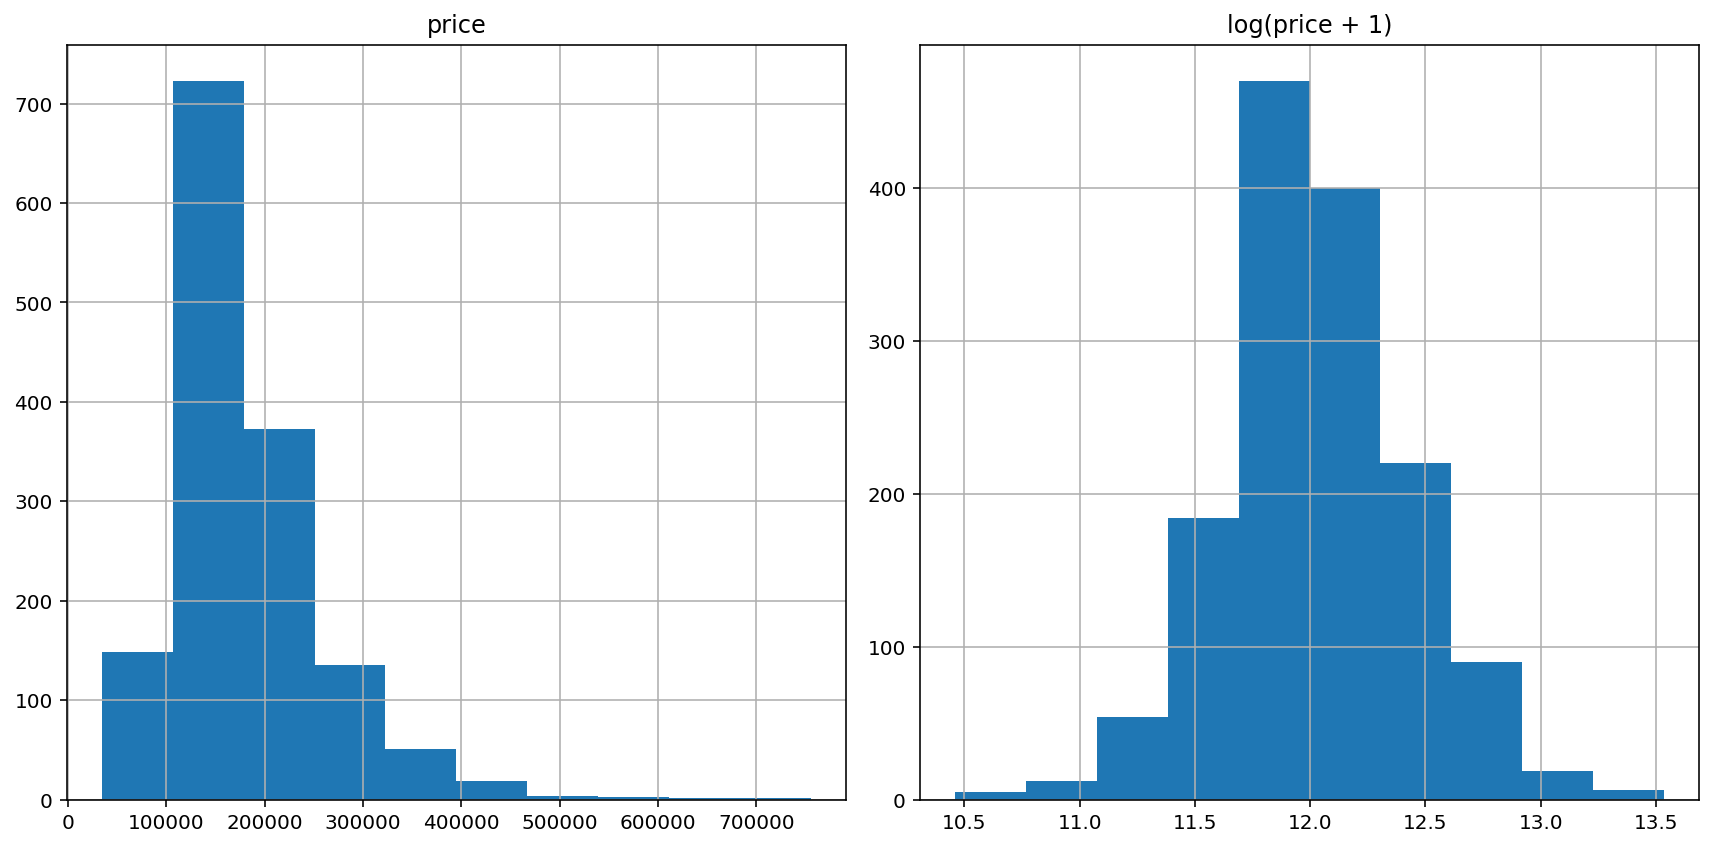

In [64]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'price' : train['SalePrice'], 'log(price + 1)' : np.log1p(train['SalePrice'])})
prices.hist()
plt.tight_layout()
plt.show()

In [65]:
# log transform the target:
train['SalePrice'] = np.log1p(train['SalePrice'])

# log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [66]:
all_data = pd.get_dummies(all_data)

In [67]:
# filling NA;s with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [68]:
# creating metrices for sklearn
X_train = all_data[:train.shape[0]]
X_test  = all_data[train.shape[0]:]
y = train.SalePrice

### Models
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par.

In [69]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring = 'neg_mean_squared_error', cv = 5))
    return(rmse)

In [70]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [71]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
           for alpha in alphas]

Text(0, 0.5, 'rmse')

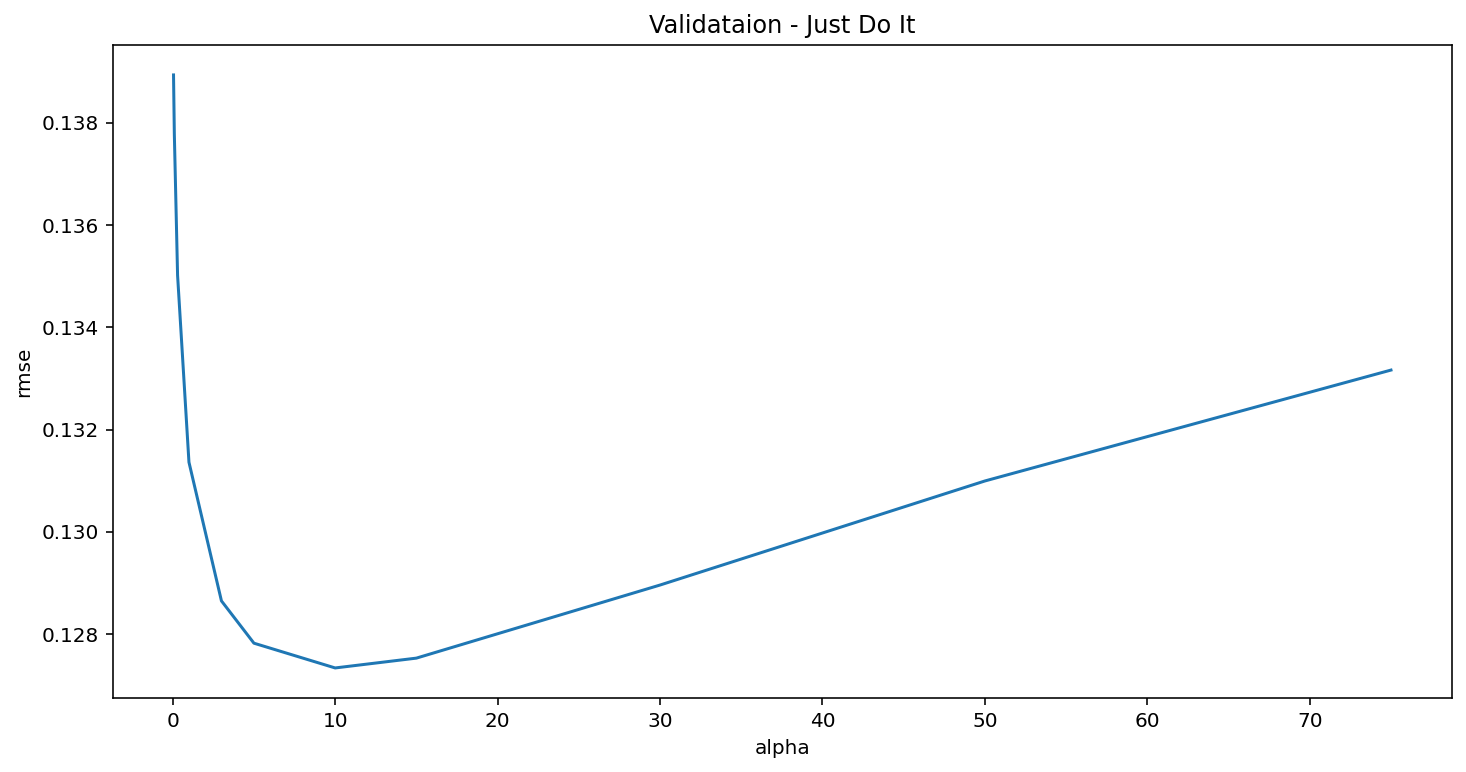

In [72]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = 'Validataion - Just Do It')
plt.xlabel('alpha')
plt.ylabel('rmse')

Note the U-ish shaped curve above. When alpha is too large the regularization too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [73]:
cv_ridge.min()

0.12733734668670754

So for the Ridge regression we get a rmsle of about 0.01

Let's try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse of the alphas in Ridge.

In [74]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [75]:
rmse_cv(model_lasso).mean()

0.12256735885048142

Nice! The lasso performs even better so we'll just use this one to predict on the test set.(기존 노트북에서의 결과, 해당 노트북에서는 ridge가 더 좋은 모델로 나옴) Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [76]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [77]:
print('Lasso picked ' + str(sum(coef != 0)) + ' variables and eliminated the other ' +
      str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Good job Lasso. One thing to note here however is that the features selected are not necessarily the correct ones sepecially since there are a lot of collinear features in this dataset. One idea to try here is un Lasso a few times on boostrapped samples and see how stable the feature selection is.


We can also take a look directly at that the most important coefficients are:

In [78]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

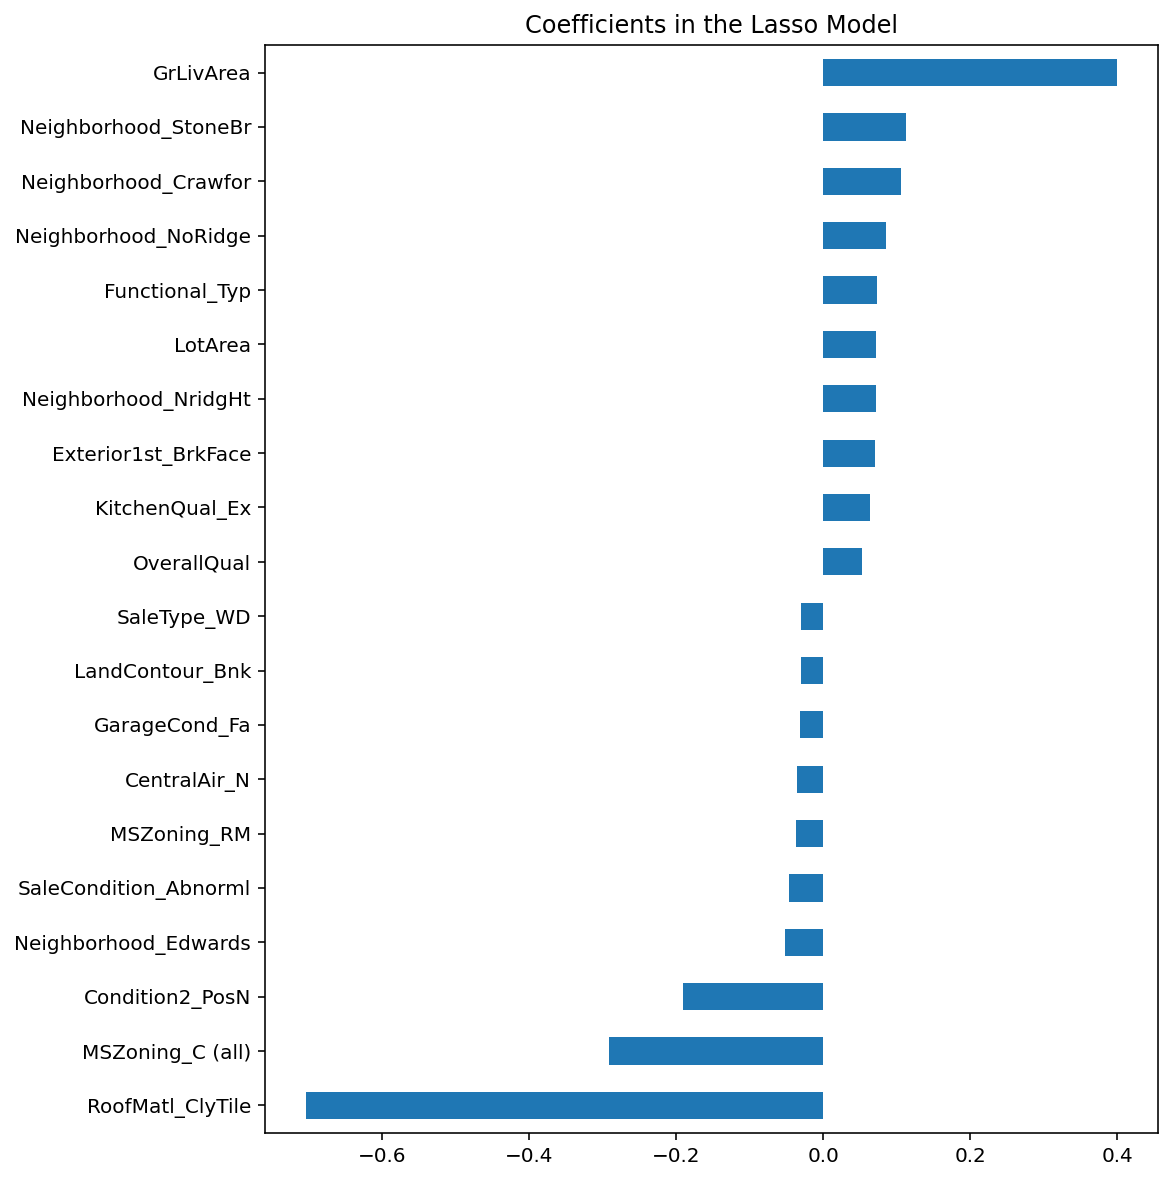

In [79]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title('Coefficients in the Lasso Model')
plt.show()

The most important positive feature is GrLivArea - the above ground area by square feet. This definitely sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - So you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the nemeric features so the actual magnitudes are a bit hard to interpret.

<AxesSubplot:xlabel='preds', ylabel='residuals'>

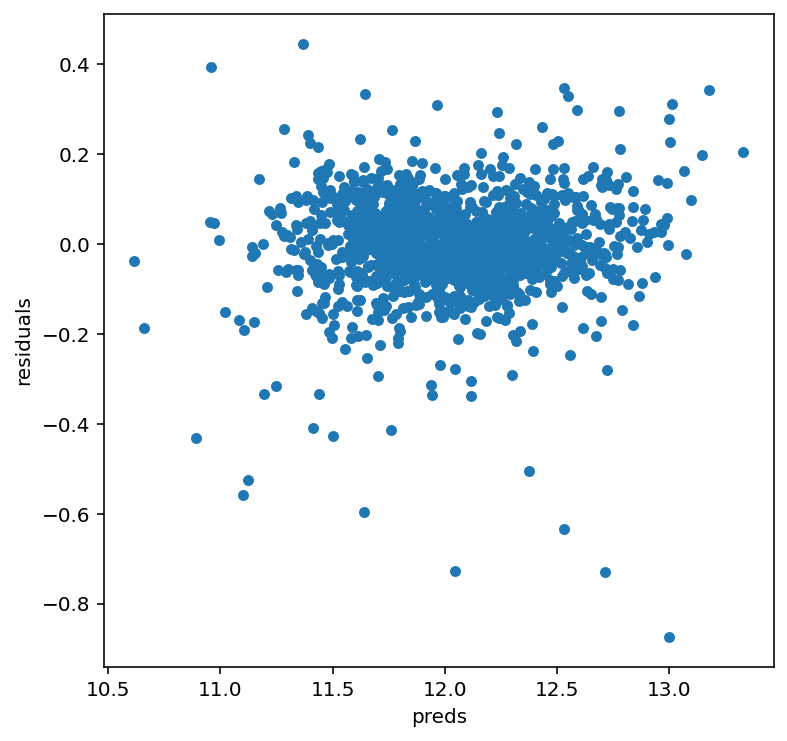

In [80]:
# let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6, 6)

preds = pd.DataFrame({'preds' : model_lasso.predict(X_train), 'True' : y})
preds['residuals'] = preds['True'] - preds['preds']
preds.plot('preds', 'residuals', kind = 'scatter')

The residual plot looks pretty good. To wrap it up let's predict on the test set and submit on the leaderboard.

### Adding an xgboost model:
Let's add an xgboost model to our linear model to see if we can improve our score:

In [81]:
import xgboost as xgb

In [82]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth' : 2, 'eta' : 0.1}
model = xgb.cv(params, dtrain, num_boost_round = 500, early_stopping_rounds = 100)

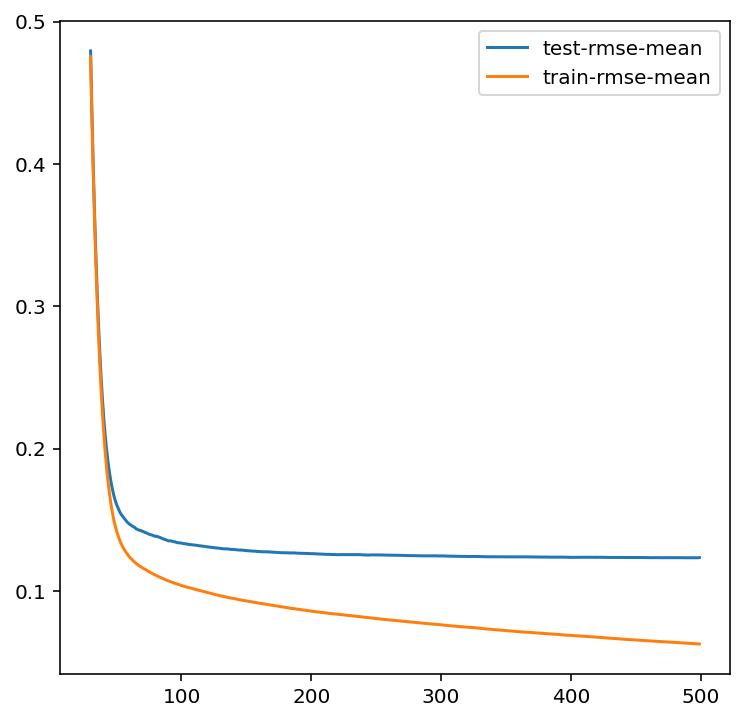

In [83]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

In [84]:
model_xgb = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = 0.1) # the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

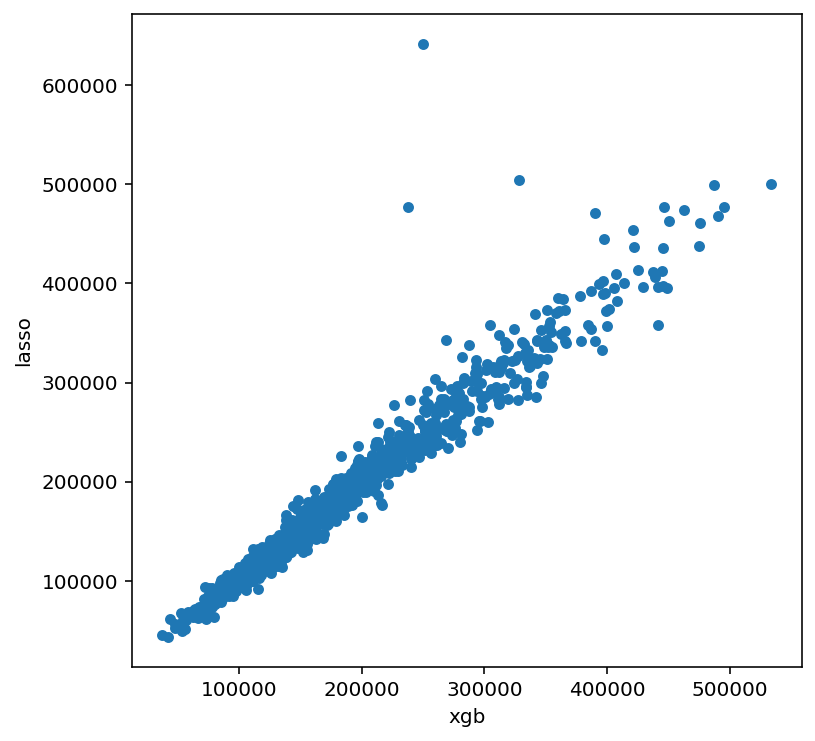

In [86]:
predictions = pd.DataFrame({'xgb' : xgb_preds, 'lasso' : lasso_preds})
predictions.plot('xgb', 'lasso', kind = 'scatter')
plt.show()

Many times it makes sense to take a weighted average of uncorrelated results - this usually improves the score although in this case it doesn't help that much.

In [87]:
preds = 0.7 * lasso_preds + 0.3 * xgb_preds

In [88]:
solution = pd.DataFrame({'id' : test.Id, 'SalePrice' : preds})
solution.to_csv('ridge_sol.csv', index = False)

### Trying out Keras?
Feed forward Neural Nets doesn't seem to work well at all... I wonder why.

In [92]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [93]:
X_train = StandardScaler().fit_transform(X_train)

In [94]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [95]:
X_tr.shape # 75%

(1095, 288)

In [99]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [104]:
model = Sequential()
# model.add(Dense(256, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], kernel_regularizer = l1(0.001)))

model.compile(loss = 'mse', optimizer = 'adam')

In [105]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [106]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

35/35 [==============================] - 0s 5ms/step - loss: 146.1958 - val_loss: 149.5659


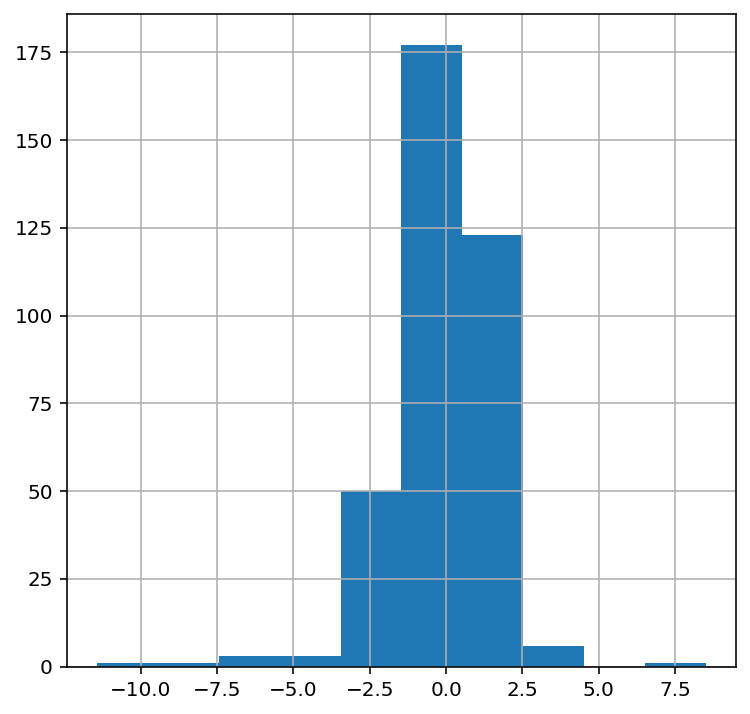

In [108]:
pd.Series(model.predict(X_val)[:, 0]).hist()
plt.show()